In [59]:
# # IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# # RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
# import kagglehub
# kagglehub.login()

In [60]:
# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.

# ftwue_path = kagglehub.competition_download('ftwue')

# print('Data source import complete.')


In [61]:
# Load data via folder structure

ftwue_path = 'data'

# Foot Traffic in Würzburg

### Short Kaggle Info

In [62]:
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

## Exploratory Data Analysis (EDA)

In [63]:
# Libraries

import numpy as np
import pandas as pd

In [64]:
sample_submission_df = pd.read_csv(f'{ftwue_path}/sample_submission.csv')
sample_submission_df

,id,n_pedestrians,n_pedestrians_towards,n_pedestrians_away
0,Schoenbornstrasse_2024-09-16_0,85.032614,40.935775,44.096839
1,Schoenbornstrasse_2024-09-16_1,46.097341,23.102860,22.994481
2,Schoenbornstrasse_2024-09-16_2,28.000502,14.102860,13.897642
3,Schoenbornstrasse_2024-09-16_3,21.362770,10.902659,10.460110
4,Schoenbornstrasse_2024-09-16_4,19.870045,8.812845,11.057200
...,...,...,...,...
1003,Kaiserstrasse_2024-09-29_19,1162.651811,551.877437,610.774373
1004,Kaiserstrasse_2024-09-29_20,605.877437,278.065460,327.811978
1005,Kaiserstrasse_2024-09-29_21,396.770195,178.065460,218.704735
1006,Kaiserstrasse_2024-09-29_22,305.189415,130.176880,175.012535


In [65]:
train_df = pd.read_csv(f'{ftwue_path}/train.csv')
train_df.head(2)

,id,streetname,city,date,hour,weekday,n_pedestrians,n_pedestrians_towards,n_pedestrians_away,temperature,weather_condition,incidents,collection_type
0,Schoenbornstrasse_2019-04-02_18,Schoenbornstrasse,Wuerzburg,2019-04-02,18,Tuesday,1324,682,642,18,partly-cloudy-day,no_incident,measured
1,Schoenbornstrasse_2019-04-02_19,Schoenbornstrasse,Wuerzburg,2019-04-02,19,Tuesday,1406,708,698,16,partly-cloudy-day,no_incident,measured


In [66]:
# View initial columns
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82821 entries, 0 to 82820
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     82821 non-null  object
 1   streetname             82821 non-null  object
 2   city                   82821 non-null  object
 3   date                   82821 non-null  object
 4   hour                   82821 non-null  int64 
 5   weekday                82821 non-null  object
 6   n_pedestrians          82821 non-null  int64 
 7   n_pedestrians_towards  82821 non-null  int64 
 8   n_pedestrians_away     82821 non-null  int64 
 9   temperature            82821 non-null  int64 
 10  weather_condition      82821 non-null  object
 11  incidents              82821 non-null  object
 12  collection_type        82821 non-null  object
dtypes: int64(5), object(8)
memory usage: 8.2+ MB


In [67]:
test_df = pd.read_csv(f'{ftwue_path}/test.csv')
test_df.head(2)

,id,streetname,city,date,hour,weekday,temperature,weather_condition,incidents,collection_type
0,Schoenbornstrasse_2024-09-16_0,Schoenbornstrasse,Wuerzburg,2024-09-16,0,Monday,12,cloudy,no_incident,measured
1,Schoenbornstrasse_2024-09-16_1,Schoenbornstrasse,Wuerzburg,2024-09-16,1,Monday,12,cloudy,no_incident,measured


In [68]:
# View initial columns
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 1008 non-null   object
 1   streetname         1008 non-null   object
 2   city               1008 non-null   object
 3   date               1008 non-null   object
 4   hour               1008 non-null   int64 
 5   weekday            1008 non-null   object
 6   temperature        1008 non-null   int64 
 7   weather_condition  1008 non-null   object
 8   incidents          1008 non-null   object
 9   collection_type    1008 non-null   object
dtypes: int64(2), object(8)
memory usage: 78.9+ KB


In [69]:
json_locations = open(f'{ftwue_path}/counterGeoLocations.json', 'r')
print(json_locations.read())
# json_locations.close()

[{"id": 476, "counter_street_name": "Kaiserstra\u00dfe", "city": "W\u00fcrzburg", "geo_shape": {"type": "Feature", "geometry": {"coordinates": [[[9.933534264564514, 49.79767989935027], [9.934167265892029, 49.79879140391002], [9.934676885604858, 49.79962588121911], [9.934483766555786, 49.79967089410911], [9.933979511260986, 49.798832954987645], [9.9334055185318, 49.79787727118186], [9.933443069458008, 49.797859957895504], [9.933362603187561, 49.797742227384], [9.93313193321228, 49.79776300337743], [9.93312656879425, 49.79773876471757], [9.933255314826965, 49.79744443716551], [9.933432340621948, 49.79751715355065], [9.933518171310425, 49.79751369086812], [9.933534264564514, 49.79767989935027]]], "type": "Polygon"}, "properties": {}}, "geo_point_2d": {"lon": 9.933887635731686, "lat": 49.798498976405355}},{"id": 470, "counter_street_name": "Spiegelstra\u00dfe", "city": "W\u00fcrzburg", "geo_shape": {"type": "Feature", "geometry": {"coordinates": [[[9.934698343276976, 49.7948335003235], [9.

In [70]:
## Setting the features and target variables

In [71]:
y = train_df["n_pedestrians"]
X = X = train_df.drop(columns=["n_pedestrians"])

print(X.shape)  # (82821, 12) -> X features
print(y.shape)  # (82821,) -> y target variable (demand)

(82821, 12)
(82821,)


In [72]:
# Add feature: Season

X['date'] = pd.to_datetime(X['date'])

# New columns: Extract the missing date features (month and year)
X['month'] = X['date'].dt.month
X['year'] = X['date'].dt.year

# Map months to seasons
X['season'] = X['month'].apply(lambda x:
    'winter' if x in [12, 1, 2] else
    'spring' if x in [3, 4, 5] else
    'summer' if x in [6, 7, 8] else
    'autumn'
)

In [73]:
print(train_df['weekday'].unique())

['Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday']


In [74]:
# Create one-hot encodings

train_df['is_weekend'] = train_df['weekday'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
X = pd.get_dummies(X, columns=["year","weekday","month","streetname","season"])

In [75]:
# View columns
X.columns

Index(['id', 'city', 'date', 'hour', 'n_pedestrians_towards',
       'n_pedestrians_away', 'temperature', 'weather_condition', 'incidents',
       'collection_type', 'year_2019', 'year_2020', 'year_2021', 'year_2022',
       'year_2023', 'year_2024', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'streetname_Kaiserstrasse',
       'streetname_Schoenbornstrasse', 'streetname_Spiegelstrasse',
       'season_autumn', 'season_spring', 'season_summer', 'season_winter'],
      dtype='object')

**Ensuring data coverage by street**

In [76]:
data = train_df.copy()

# Dictionary to store the full time series DataFrame for each streetname combination
street_time_series_dict = {}

# Iterate over each group and store the full DataFrame as the time series
for streetname, group in data.groupby('streetname'):  # Group only by 'streetname', no tuple
    # Sort the group by 'date' to ensure chronological order
    group = group.sort_values(by='date')

    # Include both 'n_pedestrians_towards' and 'n_pedestrians_away' in the time series
    time_series_df = group[['date', 'n_pedestrians_towards', 'n_pedestrians_away']].copy()

    # Add a total pedestrians column
    time_series_df['total_pedestrians'] = group['n_pedestrians_towards'] + group['n_pedestrians_away']

    # Store the full time series DataFrame for this streetname
    street_time_series_dict[streetname] = time_series_df

# Display an example of a time series for a specific streetname (optional)
for key, time_series in street_time_series_dict.items():
    print(f"Time series for {key}:\n", time_series.head())
    # break  # Uncomment if you only want to see one street's time series

Time series for Kaiserstrasse:
              date  n_pedestrians_towards  n_pedestrians_away  \
65591  2022-09-29                     11                  46   
65614  2022-09-29                     45                  35   
65613  2022-09-29                     56                  90   
65612  2022-09-29                     84                 125   
65611  2022-09-29                    206                 223   

       total_pedestrians  
65591                 57  
65614                 80  
65613                146  
65612                209  
65611                429  
Time series for Schoenbornstrasse:
          date  n_pedestrians_towards  n_pedestrians_away  total_pedestrians
0  2019-04-02                    682                 642               1324
1  2019-04-02                    708                 698               1406
2  2019-04-02                    348                 328                676
3  2019-04-02                    205                 154                359
4  20

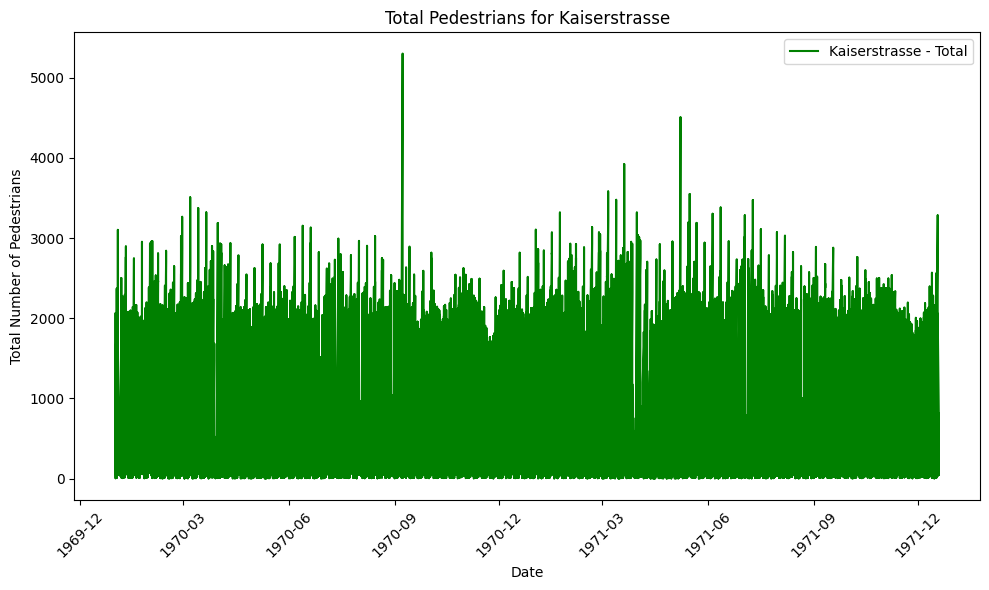

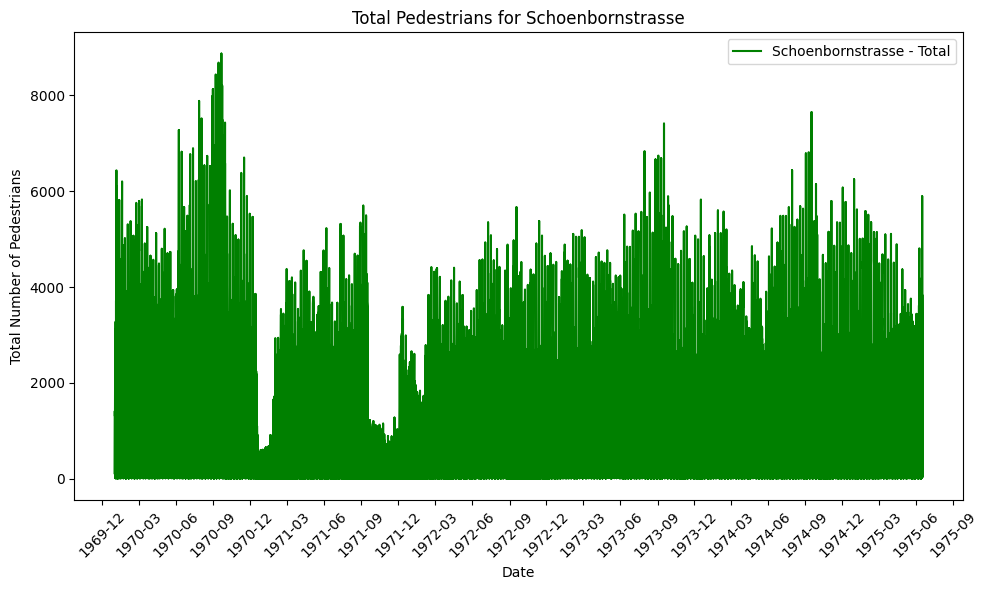

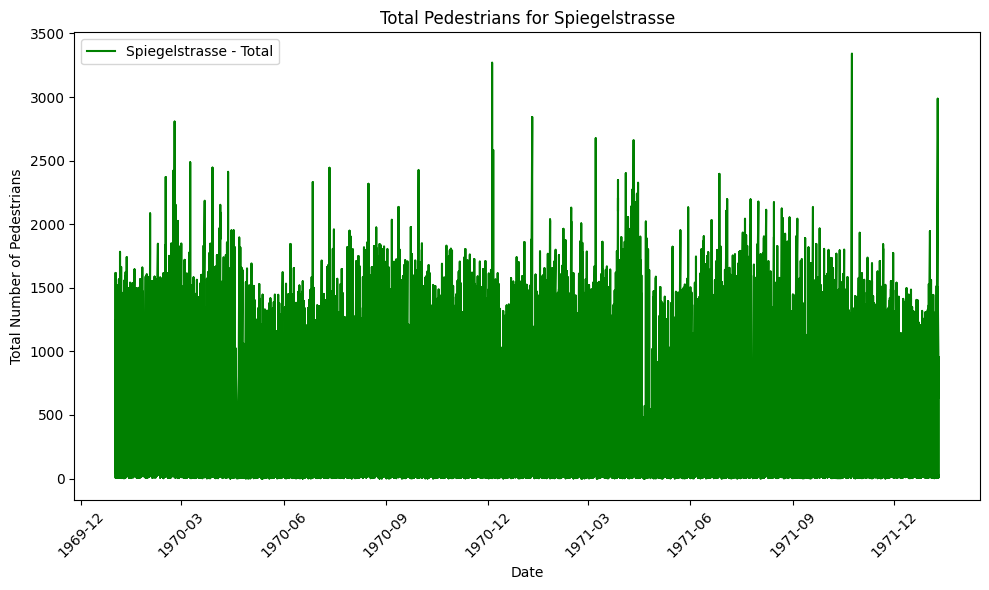

In [77]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Loop through each street and plot the total pedestrians time series
for streetname, time_series in street_time_series_dict.items():
    plt.figure(figsize=(10, 6))  # Create a new figure for each street

    # Plot total pedestrians
    plt.plot(time_series['date'], time_series['total_pedestrians'], label=f'{streetname} - Total', color='green')

    # Add title and labels
    plt.title(f'Total Pedestrians for {streetname}')
    plt.xlabel('Date')
    plt.ylabel('Total Number of Pedestrians')

    # Format the x-axis to show quarterly ticks (every 3 months)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=3))  # Every 3 months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Month

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add a legend
    plt.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show plot
    plt.show()


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Using a standard scaler only on continuous variables

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X contains your features and y your target

# Separate the date column from X for train-test splitting
date_column = X['date']  # Keep date separately for reference (if you want to use it later)

# Perform train-test split without 'date' column (already done previously)
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=['date']), y, train_size=0.75, shuffle=True
)

# Standardization (scaling) for continuous features
scaler = StandardScaler()
scaler.fit(X_train[['n_pedestrians_towards', 'n_pedestrians_away', 'temperature']])  # Use continuous columns

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[['n_pedestrians_towards', 'n_pedestrians_away', 'temperature']] = scaler.transform(X_train[['n_pedestrians_towards', 'n_pedestrians_away', 'temperature']])
X_test_scaled[['n_pedestrians_towards', 'n_pedestrians_away', 'temperature']] = scaler.transform(X_test[['n_pedestrians_towards', 'n_pedestrians_away', 'temperature']])

# Reset the indices of the train and test sets to ensure alignment
X_train_scaled.reset_index(drop=True, inplace=True)
X_test_scaled.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Concatenate date, scaled features X and scaled target y for train and test sets
train_data = pd.concat([date_column.loc[X_train.index].reset_index(drop=True), X_train_scaled, y_train], axis=1)
test_data = pd.concat([date_column.loc[X_test.index].reset_index(drop=True), X_test_scaled, y_test], axis=1)

# Print the info of the train_data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62115 entries, 0 to 62114
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          62115 non-null  datetime64[ns]
 1   id                            62115 non-null  object        
 2   city                          62115 non-null  object        
 3   hour                          62115 non-null  int64         
 4   n_pedestrians_towards         62115 non-null  float64       
 5   n_pedestrians_away            62115 non-null  float64       
 6   temperature                   62115 non-null  float64       
 7   weather_condition             62115 non-null  object        
 8   incidents                     62115 non-null  object        
 9   collection_type               62115 non-null  object        
 10  year_2019                     62115 non-null  bool          
 11  year_2020                   

### Aggregation by month and year for seasonal analysis

In [79]:
# If needed, aggregate by 'year-month' for both train and test sets
train_data['year_month'] = train_data['date'].dt.to_period('M').dt.to_timestamp()
test_data['year_month'] = test_data['date'].dt.to_period('M').dt.to_timestamp()

# Group by year-month and aggregate the 'demand' values
train_df = train_data.groupby('year_month').agg({'n_pedestrians': 'sum'}).reset_index()
test_df = test_data.groupby('year_month').agg({'n_pedestrians': 'sum'}).reset_index()

# Count the number of unique year-month values in the train set
print(train_df['year_month'].count())  # This will show the number of months in the training data

66


## Filter data: Drop lines with incidents and construction sites

In [80]:
count = ((train_data['collection_type'] == 'measured') & (train_data['incidents'] == 'no_incident')).sum()
print(f"Rows without any incident: {count}")

count = ((train_data['collection_type'] == 'measured') & (train_data['incidents'] == 'no_incident')).sum()
print(f"Rows without any incident: {count}")

Rows without any incident: 59781
Rows without any incident: 59781


In [81]:
# Create a filtered dataset: reliable without incidents 
# Drop laser failure due to sample size <30 (24)
# Drop construction site due to misrepresentation and sample size = 845
# then drop incidents

train_data_filtered = train_data[
    (train_data.get('collection_type') == 'measured') &
    (train_data.get('incidents') == 'no_incident')
]

train_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59781 entries, 0 to 62114
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          59781 non-null  datetime64[ns]
 1   id                            59781 non-null  object        
 2   city                          59781 non-null  object        
 3   hour                          59781 non-null  int64         
 4   n_pedestrians_towards         59781 non-null  float64       
 5   n_pedestrians_away            59781 non-null  float64       
 6   temperature                   59781 non-null  float64       
 7   weather_condition             59781 non-null  object        
 8   incidents                     59781 non-null  object        
 9   collection_type               59781 non-null  object        
 10  year_2019                     59781 non-null  bool          
 11  year_2020                     597

In [82]:
train_data_filtered = train_data_filtered.drop(['collection_type', 'incidents','city'], axis=1)

In [85]:
train_data_filtered.columns

Index(['date', 'id', 'hour', 'n_pedestrians_towards', 'n_pedestrians_away',
       'temperature', 'weather_condition', 'year_2019', 'year_2020',
       'year_2021', 'year_2022', 'year_2023', 'year_2024', 'weekday_Friday',
       'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'streetname_Kaiserstrasse', 'streetname_Schoenbornstrasse',
       'streetname_Spiegelstrasse', 'season_autumn', 'season_spring',
       'season_summer', 'season_winter', 'n_pedestrians', 'year_month'],
      dtype='object')

## Run some sample models

**Models - Note on dropping the date column**


When to keep the date column:

**Trend or sequential models**

For **time-series forecasting models** (e.g., ARIMA, LSTMs), date plays a critical role since the sequential order of the data matters.
If you're using date to create **lagged features, rolling averages, or trends,** it must remain in the dataset.

**Seasonality and trend extraction:**
If you plan to create additional features like is_holiday, is_weekend, or extract temporal trends (e.g., exponential smoothing or Fourier terms), keeping date as a reference can be useful.
Auditing and Interpretability:

Keeping date in your dataset during exploratory analysis can help track model performance over time and assess how predictions vary with date-specific patterns.

---
When to drop:

If you’ve already derived features like weekday, hour, and other relevant temporal indicators, dropping date is fine for most traditional ML models (like regression, decision trees, etc.). However, if you're working on a time-series model or need the date column for feature engineering, then keep it.

In [89]:
# Train-test split for each of the 3 target variables

target_columns = ['n_pedestrians', 'n_pedestrians_towards', 'n_pedestrians_away']

X_train, X_test, y_train, y_test = train_test_split(
    train_data_filtered.drop(target_columns, axis=1),  # dropping the target columns y, keeping features X
    train_data_filtered['n_pedestrians'], # first target variable
    test_size=0.25, 
    random_state=1000  # setting a seed 
)

### RNN